# Create Monthly NDVI composites using Harmonized Landsat Sentinel (HLS) data from NASA CMR STAC api using `pystac_client` & `stackstac` 

In this tutorial we will do the following tasks:

1. Use leafmap to select an Area of Interest (AOI) and save it as a geojson
2. Explore NASA CMR STAC API using `pystac_client` CLI & Python API
3. Understand & visualize the availability of Harmonized Landsat Sentinel (HLS) data for an AOI
4. Use `dask` and `stackstac` to pull data efficiently
5. Load the data as lazy `xarrays`, filter by cloudcover, compute NDVI & create monthly composites
6. Visualize the evolution of beautiful crop circles over time

Before starting this tutorial make sure you signed-up for https://urs.earthdata.nasa.gov/ & have a `.netrc` file configured. If not please [run this script](https://git.earthdata.nasa.gov/projects/LPDUR/repos/daac_data_download_python/browse/EarthdataLoginSetup.py) before proceeding any further.

In [1]:
# Import all the packages we will be using in our workflow
import json
import warnings
import os
from pathlib import Path

import leafmap
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
import stackstac
import xarray as xr
from dask import distributed
from geojson_rewind import rewind
from osgeo import gdal
from pystac_client import Client
from IPython import display

warnings.filterwarnings('ignore')

### Set GDAL configuration to successfully access LP DAAC Cloud Assets

In [2]:
rio_env = rio.Env(GDAL_DISABLE_READDIR_ON_OPEN='TRUE',
                  GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                  GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'))
rio_env.__enter__()

Create a `Path` object to `DATA` and look what we have inside it. We have a default `aoi.geojson` file that points to somewhere near Egypt's Thoshka Projekt. You can choose to use the default file or create your own AOI 

In [8]:
DATA = Path('data')
!ls {DATA}

egypt-thoska-project.geojson


# Select an AOI

We will use `leafmap` to select an AOI & save it as GeoJSON inside the `data/` folder. For reference on how to do this using leafmap please check the create_vector notebook: https://leafmap.org/notebooks/45_create_vector/

In [9]:
import leafmap.leafmap as leafmap

In [10]:
m = leafmap.Map(center=(31.5, 22.5), zoom=8, 
                draw_control=True, measure_control=False, fullscreen_control=False, attribution_control=True)
m

Map(center=[31.5, 22.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

We can check if our newly created AOI is saved inside the `data/` folder. Here I saving it as `aoi.geojson`. 

In [13]:
!ls {DATA}

aoi.geojson                  egypt-thoska-project.geojson


In [14]:
# Hack: Leaflet saves polygons in a clockwise manner in Feature Collection. We can fix this using `geojson_rewind`
aoi = json.load((DATA/"aoi.geojson").open("r"))
aoi = rewind(aoi)
json.dump(aoi, (DATA/"aoi.geojson").open("w"))
aoi

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[31.198854, 22.476446],
      [31.460311, 22.476446],
      [31.460311, 22.707661],
      [31.198854, 22.707661],
      [31.198854, 22.476446]]]}}]}

# NASA CMR STAC

NASA's Common Metadata Repository (CMR) is a metadata catalog of NASA Earth Science data. STAC, or SpatioTemporal Asset Catalog, is a specification for describing geospatial data with JSON and GeoJSON. The related STAC-API specification defines an API for searching and browsing STAC catalogs.

To know more about STAC & ARCO data formats please visit https://stacindex.org/ and https://pangeo-forge.readthedocs.io/en/latest/

In [15]:
# NASA CMR STAC URL
CMR_STAC_URL = "https://cmr.earthdata.nasa.gov/stac"
providers = Client.open(CMR_STAC_URL)

### Sub Catalog

NASA CMR STAC base catalog has a list of sub-catalog such as NOAA, JAXA, LPCLOUD etc. Let us list them down here for reference.

In [17]:
for provider in providers.get_children():
    print(provider.title)

LARC_ASDC
USGS_EROS
ESA
GHRC
LAADS
OBPG
OB_DAAC
ECHO
ISRO
LPCUMULUS
EDF_DEV04
GES_DISC
ASF
OMINRT
EUMETSAT
NCCS
NSIDCV0
PODAAC
LARC
USGS
SCIOPS
LANCEMODIS
CDDIS
JAXA
AU_AADC
ECHO10_OPS
LPDAAC_ECS
NSIDC_ECS
ORNL_DAAC
LM_FIRMS
SEDAC
LANCEAMSR2
NOAA_NCEI
USGS_LTA
GESDISCCLD
GHRSSTCWIC
ASIPS
ESDIS
POCLOUD
NSIDC_CPRD
ORNL_CLOUD
FEDEO
MLHUB
XYZ_PROV
GHRC_DAAC
CSDA
NRSCC
CEOS_EXTRA
MOPITT
GHRC_CLOUD
LPCLOUD
CCMEO


### We will use the Harmonised Landsat Sentinel (HLS) data available under `LPCLOUD` Sub-Catalog

HLS consists of input data from the joint NASA/USGS Landsat 8 and the ESA (European Space Agency) Sentinel-2A and Sentinel-2B satellites to generate a harmonized, analysis-ready surface reflectance data product with observations every two to three days.

# Access NASA CMR STAC LPCLOUD API using `pystac_client`

We will look at using both the python-client & CLI of `pystac_client` to access STAC data. 

## 1. `pystac_client` CLI

Here we are searching for tiles in collection "HLSS30.v2.0" & "HLSL30.v2.0" that intersects our defined AOI. We are defining the date-range between Jan-2019 to Jan-2022 & saving the results inside `data/aoi-catalog.json`

In [18]:
!stac-client search 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD' \
    --collection HLSS30.v2.0 HLSL30.v2.0 \
    --intersects {DATA/'aoi.geojson'} \
    --datetime 2019-01-01/2022-01-31 > data/aoi-catalog.json

Now, we can look manually inside the raw json file which has details about each tile like properties, bounds, assets etc.

We can also use [`stacterm`](https://github.com/stac-utils/stac-terminal) which is a library for displaying information (tables, calendars, plots, histograms) about STAC Items in the terminal to get a sense of the data coverage in our AOI.

### List down the days on which we have HLS data available 

In [19]:
!cat data/aoi-catalog.json | stacterm cal

                              2019                              

      January               February               March        
Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su
    1  2  3  4  5  6               1  2  3               1  2  3  
 7  8  9 10 11 12 13   4  5  6  7  8  9 10   4  5  6  7  8  9 10  
14 15 16 17 18 19 20  11 12 13 14 15 16 17  11 12 13 14 15 16 17  
21 22 23 24 25 26 27  18 19 20 21 22 23 24  18 19 20 21 22 23 24  
28 29 30 31           25 26 27 28           25 26 27 28 29 30 31  

       April                  May                   June        
Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su
 1  2  3  4  5  6  7         1  2  3  4  5                  1  2  
 8  9 10 11 12 13 14   6  7  8  9 10 11 12   3  4  5  6  7  8  9  
15 16 17 18 19 20 21  13 14 15 16 17 18 19  10 11 12 13 14 15 16  
22 23 24 25 26 27 28  20 21 22 23 24 25 26  17 18 19 20 21 22 23  
29 30                 27 28 29 30 31        24 25 26 27 28 29 30  

  

> We have data from only HLSL30 (Landsat) collection available till Aug 2020, HLSS30 (Sentinel) collection starts appearing from Sept, 2020. We can also represent the same data in a tabular manner by applying filter & sort functions.

In [37]:
!cat data/aoi-catalog.json | stacterm table \
    --fields collection date eo:cloud_cover \
    --sort eo:cloud_cover | head -20

| collection  | date       | eo:cloud_cover |
|-------------|------------|----------------|
| HLSS30.v2.0 | 2022-01-30 | 0              |
| HLSS30.v2.0 | 2021-12-01 | 0              |
| HLSS30.v2.0 | 2021-03-31 | 0              |
| HLSS30.v2.0 | 2021-03-31 | 0              |
| HLSS30.v2.0 | 2021-03-29 | 0              |
| HLSS30.v2.0 | 2021-12-04 | 0              |
| HLSS30.v2.0 | 2021-03-26 | 0              |
| HLSS30.v2.0 | 2021-03-26 | 0              |
| HLSS30.v2.0 | 2021-12-04 | 0              |
| HLSS30.v2.0 | 2021-03-21 | 0              |
| HLSS30.v2.0 | 2021-03-21 | 0              |
| HLSS30.v2.0 | 2021-03-19 | 0              |
| HLSS30.v2.0 | 2021-03-19 | 0              |
| HLSS30.v2.0 | 2021-03-16 | 0              |
| HLSS30.v2.0 | 2021-03-11 | 0              |
| HLSS30.v2.0 | 2021-03-11 | 0              |
| HLSL30.v2.0 | 2021-03-11 | 0              |
| HLSL30.v2.0 | 2021-03-11 | 0              |
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-

## 2. `pystac_client` Python API

Connect to the LPCLOUD CMR catalog & look at the list of available collections.

In [21]:
catalog = Client.open(f'{CMR_STAC_URL}/LPCLOUD')

collections = catalog.get_children()
for collection in collections:
    print(collection.id, collection.title)

ASTGTM.v003 ASTER Global Digital Elevation Model V003
HLSL30.v2.0 HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0
HLSS30.v2.0 HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance Daily Global 30m v2.0


> We will be using the HLSL30.v2.0 & HLSS30.v2.0 collections in this notebook

### Query the STAC catalog to access HLS data separately for Sentinel & Landsat data

We can also pass in a `query` or `filter` parameter to the `search` function to further filter down the item search results. STAC catalog search API gives us options to filter results based on spatio-temporal factors.  

In [22]:
s30 = catalog.search(
        collections=['HLSS30.v2.0'],
        intersects=aoi['features'][0]['geometry'],
        datetime='2019-01-01/2022-01-31',
)
l30 = catalog.search(
        collections=['HLSL30.v2.0'],
        intersects=aoi['features'][0]['geometry'],
        datetime='2019-01-01/2022-01-31',
)

In [23]:
s30.matched(), l30.matched()

(387, 140)

> 387 tiles of HLSS30 collection available for our AOI between Jan-2019 - Jan-2022  
> 140 tiles of HLSL30 collection available for our AOI between Jan-2019 - Jan-2022  

Read the filtered results & call `to_dict()` on them that stores them as `feature collections`

In [24]:
s30_tiles, l30_tiles = s30.get_all_items(), l30.get_all_items()
s30_tiles_json, l30_tiles_json = s30_tiles.to_dict(), l30_tiles.to_dict()

In [25]:
display.JSON(s30_tiles_json)

<IPython.core.display.JSON object>

In [26]:
display.JSON(l30_tiles_json)

<IPython.core.display.JSON object>

### Plot the tile boundaries of HLSS30 & HLSL30 collection & our AOI

Convert the `geojsons` into `GeoDataFrames` to visualize inside Leafmap. Use the layers icon to filter different tiles & hover over to look at the properties.

In [27]:
s30_tiles_gdf = gpd.GeoDataFrame.from_features(s30_tiles_json, crs="EPSG:4326")
l30_tiles_gdf = gpd.GeoDataFrame.from_features(l30_tiles_json, crs="EPSG:4326")
aoi_gdf = gpd.GeoDataFrame.from_features(aoi["features"], crs="EPSG:4326")

m = leafmap.Map(center=(40, -74), zoom=9)
m.add_gdf(s30_tiles_gdf, layer_name="Sentinel Tiles", fill_colors=["red"])
m.add_gdf(l30_tiles_gdf, layer_name="Landsat Tiles", fill_colors=["blue"])
m.add_gdf(aoi_gdf, layer_name="AOI", fill_colors=["black"], zoom_to_layer=False)
m

Map(center=[40, -74], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

# Story so far

We used `pystac_client` to query all the tiles from HLSS30 & HLSL30 collections with in our defined spatial & temporal extent. 

We want to create montly NDVI composites over our AOI. To do this we have to
- Go over each tile in the collection result from previous steps
- Download the required assets i.e NIR & Red bands
- Clip the tiles to AOI
- Compute NDVI & create a montly composite

**OR**

We can take advantage of STAC & COGs structures in NASA CMR API and use `stackstac` along with `dask` to compute montly NDVI composites over the AOI in an efficient manner without downloading & processing all the tiles. 

# Stackstac

`stackstac` converts STAC collections into lazy `xarrays`. It can read STAC metadata into xarray coordinates, that helps in indexing, filtering and computing aggregations over the dataset.  

`stackstac` can also use `dask` to perform the computations parallely.

For this example, we will create a local `dask` cluster to perform our `stackstac` operations. You can easily replace this with a cluster in the cloud to speed up the operations.

`Dask` has a nice UI that lets you visualize each step in the process and also provides information on compute & data usage. 

In [28]:
cluster = distributed.LocalCluster()
client = distributed.Client(cluster)
client

<Client: 'tcp://127.0.0.1:50208' processes=4 threads=8, memory=16.00 GiB>

In [29]:
# Configure GDAL options to access COGs from Earthdata system
dist_env = stackstac.DEFAULT_GDAL_ENV.updated(dict(
    GDAL_DISABLE_READDIR_ON_OPEN='TRUE',
    GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
    GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'))
)

# Monthly NDVI composites 

We are trying to create monthly NDVI composites from Jan 2019 - Jan 2022 for defined AOI, in this case Thoshka Projekt, Egypt. We will need `NIR` & `Red` bands to compute NDVI from Sentinel & Landsat HLS Imagery. 

**Sentinel 2**:
 - "narrow" NIR = B8A  
 - Red = B04  

**Landsat 8**:
 - NIR = B05  
 - Red = B04  

`stackstac` can convert the STAC items into lazy xarray's. We can then use them to filter by cloud cover, clip to our defined AOI, compute monthly composite etc.

Here, we define the `bbox` of our AOI, `bands` (NIR, Red) we need & the resolution of imagery to access.

In [30]:
bbox = tuple(map(float, aoi_gdf.bounds.values[0]))

s30_stack = stackstac.stack(
    s30_tiles,
    assets=['B8A', 'B04'],
    bounds_latlon=bbox,
    resolution=30,
    epsg=32636,
    gdal_env=dist_env
)
l30_stack = stackstac.stack(
    l30_tiles,
    assets=['B05', 'B04'],
    bounds_latlon=bbox,
    resolution=30,
    epsg=32636,
    gdal_env=dist_env
)

> Great, that's all there is to `stackstac`. Now we have a lazy xarray & can perform all the operations on top of it. Note: All the operations are perfomed on the metadata & actual computation happens only when you call the `persists()` or `compute()` method on lazy xarray object.

#### Fix the band mis-match in Sentinel & Landsat data

In [31]:
s30_stack.coords['band'] = ['nir', 'red']
l30_stack.coords['band'] = ['nir', 'red']

#### Combine both into a single stack

In [38]:
stack = xr.concat((s30_stack, l30_stack), dim='time').sortby("time")
stack.data

dask.array<getitem, shape=(527, 2, 864, 907), dtype=float64, chunksize=(1, 1, 864, 907), chunktype=numpy.ndarray>

#### Filter by cloud cover score

In [34]:
cloudless = stack[stack['eo:cloud_cover'] < 10]

#### Compute NDVI for the AOI

In [35]:
nir, red = cloudless.sel(band='nir'), cloudless.sel(band='red')
ndvi = (nir - red)/((nir + red) + 1e-10)

#### Monthy composite with median

In [39]:
ndvi_monthly = ndvi.resample(time='M').median(dim='time')
ndvi_monthly.data

dask.array<where, shape=(37, 864, 907), dtype=float64, chunksize=(2, 432, 907), chunktype=numpy.ndarray>

#### Do the actual computation

With `stackstac` we are not pulling all the tiles into our machine (which would have been several GBs), but just a subset of it i.e our AOI. You can monitor the progress using the dask UI.

In [34]:
data = ndvi_monthly.compute()

/Users/srm/mambaforge/envs/geobox/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


#### Save the compute DataArray in NetCDF format

In [35]:
data.to_netcdf('data/egypt-thoska-ndvi-egypt.nc')

#### Visualize the NDVI composites

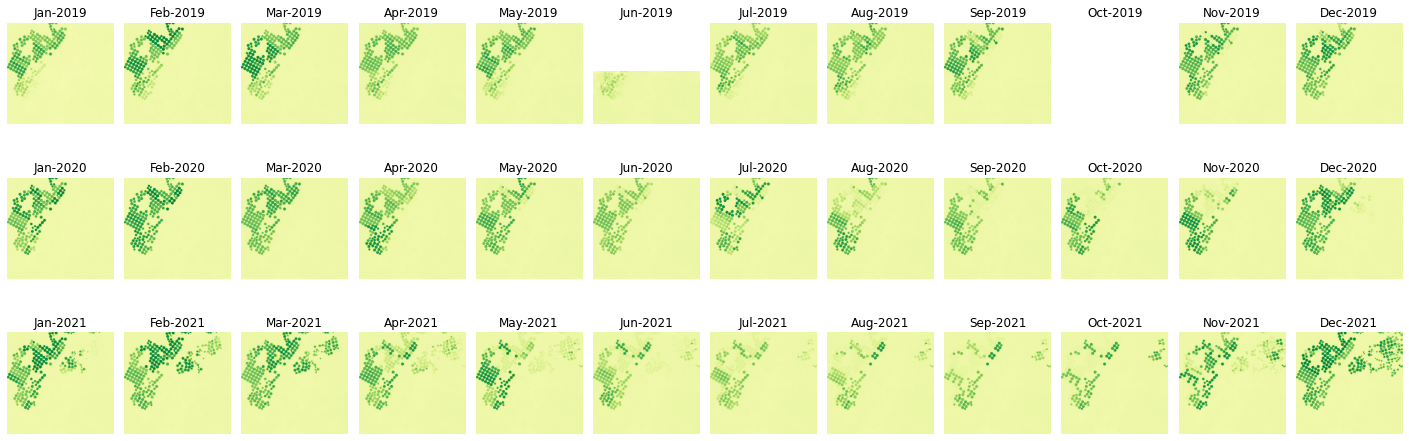

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=12, figsize=(25,25))

for idx, ax in enumerate(axes.flatten()):
    datum = data.isel(time=idx)
    ax.imshow(datum, vmin=-1, vmax=1, cmap='RdYlGn')
    ax.set_title(datum.time.dt.strftime("%b-%Y").values)
    ax.set_axis_off()
    plt.subplots_adjust(hspace=0.1, wspace=0.1, bottom=0.2, top=0.45)

> Ahh finally! We can see the beautiful crop circles evolving over time as a result of center-pivot irrigation.